Fashion-MNIST Image Classification using PyTorch

Installation & Imports

Purpose: Install required packages and import libraries used throughout the notebook.


import ... brings in PyTorch modules (torch, nn, optim), data utilities (DataLoader, datasets, transforms) and plotting (matplotlib.pyplot).
> Add blockquote



In [1]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


device = torch.accelerator.device gets the accelerator device.

print("Using device:", device) shows which device will be used.

Tip: Make sure you enabled GPU in Colab via Runtime → Change runtime

Dataset & DataLoader


Download Fashion-MNIST and prepare fast batched iterators for training and testing.
transform = transforms.Compose([...]) defines preprocessing: convert to tensor and normalize pixel values.

datasets.FashionMNIST(..., download=True, transform=transform) downloads the dataset and applies the transform.

DataLoader(..., batch_size=64, shuffle=True) wraps the dataset into batches and shuffles training data.
Tip: Normalization (0.5, 0.5) centers pixel values around 0 which helps training stability.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transform),
    batch_size=64
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.1MB/s]


model - CNN


class CNN(nn.Module): defines the model as a PyTorch nn.Module.

nn.Conv2d, nn.MaxPool2d define convolution and pooling layers to extract features.

nn.Linear layers act as the final classifier after flattening feature maps.

nn.Dropout(0.25) reduces overfitting by randomly dropping activations during training.

forward(self, x) implements the forward pass using F.relu activations and pooling.
Tip: The x.view(-1, 64*7*7) flattens the tensor for the dense layer — changing conv/filter sizes will require updating this value.


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*7*7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.drop  = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

model = CNN().to(device)

Loss & Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Lopp

for epoch in range(5): runs 5 training cycles.

model.train() enables training mode (dropout on).

For every batch:

Move images + labels to GPU/CPU.

Reset gradients with optimizer.zero_grad().

Forward pass → compute loss.

Backward pass → update weights.

running_loss stores total loss for the epoch.

Print the average loss after each epoch.

 Training for more epochs (10–20) usually gives higher accuracy.

In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)  # accumulate batch loss

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/5], Loss: 0.4589
Epoch [2/5], Loss: 0.2976
Epoch [3/5], Loss: 0.2537
Epoch [4/5], Loss: 0.2248
Epoch [5/5], Loss: 0.2014


In [6]:
#Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds == labels).sum().item()
print(f"Test Accuracy: {100*correct/len(test_loader.dataset):.2f}%")


Test Accuracy: 91.56%


In [ ]:
 #Visualize Predictions

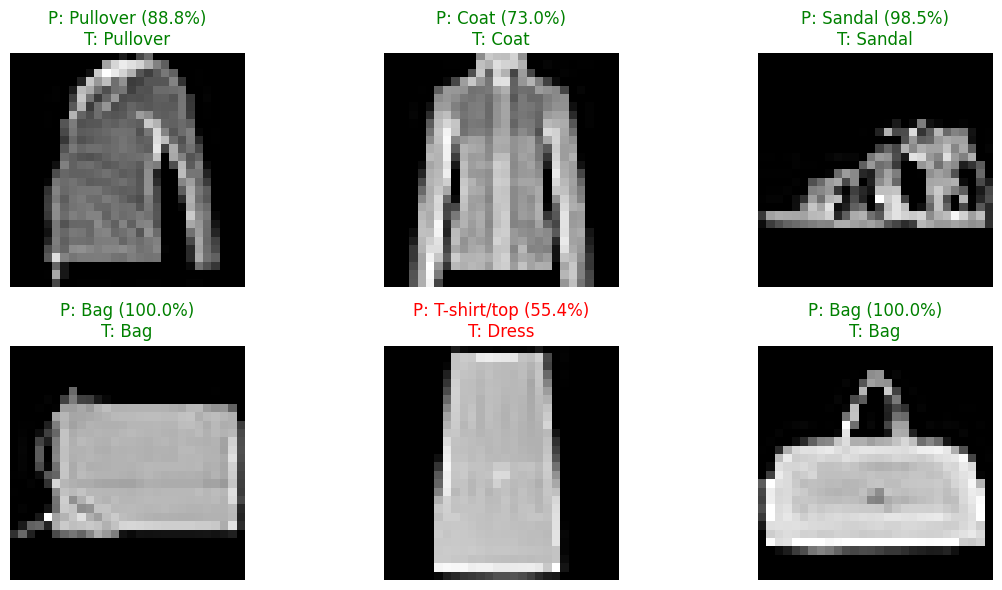

In [12]:


# Classes
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

# Get a random batch
imgs, labels = next(iter(test_loader))
imgs, labels = imgs.to(device), labels.to(device)
outputs = model(imgs)
probs = torch.softmax(outputs, dim=1)
preds = probs.argmax(1)

# Pick 6 random indices from batch
indices = random.sample(range(len(imgs)), 6)

fig, axes = plt.subplots(2, 3, figsize=(12,6))
for ax, idx in zip(axes.flatten(), indices):
    img = imgs[idx].cpu().squeeze()
    pred_class = classes[preds[idx]]
    true_class = classes[labels[idx]]
    confidence = probs[idx, preds[idx]].item() * 100

    # Color: green if correct, red if wrong
    color = 'green' if preds[idx] == labels[idx] else 'red'

    ax.imshow(img, cmap='gray')
    ax.set_title(f"P: {pred_class} ({confidence:.1f}%)\nT: {true_class}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()
